In [1]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import *
import statsmodels.stats.multitest as smm
import scipy
import seaborn as sns

In [2]:
data = pd.read_csv("data/credit_card_default_analysis.csv")

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Задание 1

#### Гипотеза:   

a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки против обратной

In [4]:
ret = data.query("default == 0")
not_ret = data.query("default == 1")

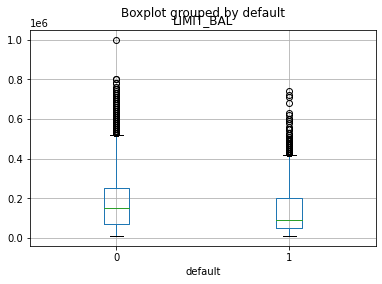

In [5]:
data.boxplot(column=["LIMIT_BAL"], by="default");

In [6]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [7]:
np.random.seed(0)

ret_med_sample_lim = list(map(np.median, get_bootstrap_samples(ret.LIMIT_BAL.values, 10000)))
not_ret_med_sample_lim = list(map(np.median, get_bootstrap_samples(not_ret.LIMIT_BAL.values, 10000)))

print("95% confidence interval for the return debt LIMIT_BAL:",  stat_intervals(ret_med_sample_lim, 0.05))
print("95% confidence interval for the not return debt LIMIT_BAL:",  stat_intervals(not_ret_med_sample_lim, 0.05))

95% confidence interval for the return debt LIMIT_BAL: [150000. 150000.]
95% confidence interval for the not return debt LIMIT_BAL: [80000. 90000.]


In [8]:
print("difference between medians:", np.median(ret_med_sample_lim) - np.median(not_ret_med_sample_lim))

difference between medians: 60000.0


b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

In [9]:
stats.mannwhitneyu(ret.LIMIT_BAL.values, not_ret.LIMIT_BAL.values)

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223303e-189)

Результаты значимы как практически (разница между медианами достаточно большая), так и статистически.  
H0 отвергается на достигаемом уровне значимости 1.2255485818223303e-189

### Задание 2

Пол (SEX)  
Гипотеза о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается против альтернативы

In [10]:
ret_sex = ret.SEX
not_ret_sex = not_ret.SEX

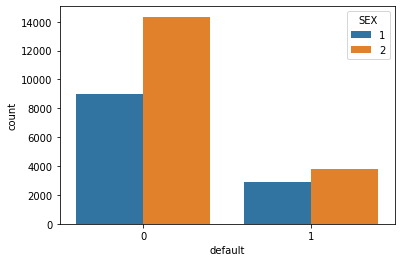

In [11]:
sns.countplot(x="default", hue="SEX", data=data);

In [12]:
ret_sex.value_counts(), not_ret_sex.value_counts()

(2    14349
 1     9015
 Name: SEX, dtype: int64,
 2    3763
 1    2873
 Name: SEX, dtype: int64)

In [13]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    print("Доля в вернувших: {}, Доля в неплателщиках: {}".format(p1, p2))
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [14]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(ret_sex - 1, not_ret_sex - 1))

Доля в вернувших: 0.6141499743194658, Доля в неплателщиках: 0.5670584689572031
95% confidence interval for a difference between proportions: [0.033635, 0.060548]


In [15]:
print("p-value: {}".format(proportions_diff_z_test(proportions_diff_z_stat_ind(ret_sex - 1, not_ret_sex - 1))))

p-value: 4.472866521609831e-12


С p-value = 4.472866521609831e-12 на уровне значимости 0.05 гипотеза об отсутствии связи между полом и возвратом кредита отвергается  
в пользу двухсторонней альтернативы. Доверительный интервал говорит, что среди неплательщиков больше доля женщин, чем в случае погашения долга  
Результат может иметь практическую значимость

### Задание 3

Образование (EDUCATION)

Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг, против двухсторонней альтернативы

In [16]:
ret_ed = ret.EDUCATION
not_ret_ed = not_ret.EDUCATION

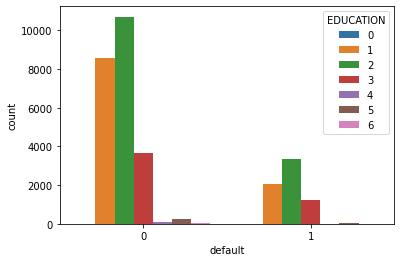

In [17]:
sns.countplot(x="default", hue="EDUCATION", data=data);

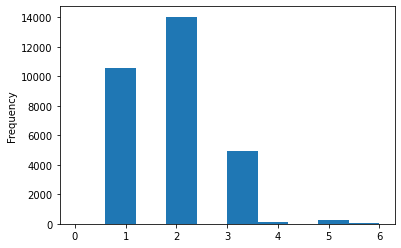

In [18]:
data.EDUCATION.plot.hist();

Предположим, что образование не играет роли в прогнозе, H0 - наблюдаемые данные имеют заданные частоты возврата

In [92]:
H0_p = len(not_ret) / (len(ret) + len(not_ret))
H0_p

0.2212

Предположим, что образование никак не влияет на возрат долга, тогда вероятность невозврата по каждому значению  
образования одинакова, вероятность не вернуть долг в каждом случае образованности должна быть примерно равна 0.2212.   
Составим таблицу разности отношений не вернувших долг к тем, кто его вернул.  
Проверим гипотезу о равности распределения нашей выборки сгенерированному против двухсторонней альтернативы

In [111]:
data_ed_agg = data.groupby("EDUCATION").agg({"default": "value_counts"})
data_ed_agg = data_ed_agg.unstack().fillna(0)
data_ed_agg.columns = [0, 1]

data_ed_agg_exp = data_ed_agg * 0


data_ed_agg_exp[1] = data_ed_agg.sum(axis=1) * (H0_p)
data_ed_agg_exp[0] = data_ed_agg.sum(axis=1) * (1 - H0_p)

Сравним количество

In [119]:
data_ed_agg.sum(axis=1) - data_ed_agg_exp.sum(axis=1)

EDUCATION
0    1.776357e-15
1    0.000000e+00
2    1.818989e-12
3    0.000000e+00
4    1.421085e-14
5    0.000000e+00
6    7.105427e-15
dtype: float64

Округлять я не буду, поскольку тогда общая сумма событий в data_ed_agg_exp измениться на 1 и применить хи квадрат уже будет невозможно

In [120]:
data_ed_obs_exp = pd.concat([data_ed_agg, data_ed_agg_exp], axis=1, )
data_ed_obs_exp.columns = ["obs_back", "obs_not_back", "exp_back", "exp_not_back"]

In [121]:
data_ed_obs_exp

,obs_back,obs_not_back,exp_back,exp_not_back
EDUCATION,,,,
0,14.0,0.0,10.9032,3.0968
1,8549.0,2036.0,8243.5980,2341.4020
2,10700.0,3330.0,10926.5640,3103.4360
3,3680.0,1237.0,3829.3596,1087.6404
4,116.0,7.0,95.7924,27.2076
5,262.0,18.0,218.0640,61.9360
6,43.0,8.0,39.7188,11.2812


Мы видим, что частоты возврата сильно больше 5, а значит мы можем использовать критерий Хи квадрат

In [122]:
sum(data_ed_agg_exp[0].values)

23363.999999999993

In [123]:
sum(data_ed_agg[0].values)

23364.0

In [156]:
scipy.stats.chisquare(data_ed_agg[0].values, data_ed_agg_exp[0].values)

Power_divergenceResult(statistic=7.888521958555138, pvalue=0.04837268928031174)

С достигаемым уровнем значимости 0.04837268928031174 при уровне значимости 0.05 мы можем отклонить гипотезу о равенстве частот возврата долга двух распределений в пользу H1

Выведем наглядную таблицу, устойчивую к маштабу:

In [134]:
data_ed_agg / data_ed_agg_exp

,0,1
EDUCATION,,
0,1.284027,0.000000
1,1.037047,0.869564
2,0.979265,1.073004
3,0.960996,1.137324
4,1.210952,0.257281
5,1.201482,0.290623
6,1.082611,0.709144


Если значение больше > 1 в колонке 0, то количество людей, вернувших долг выше, чем ожидалось и наоборот  
Аналогично для столбца 1

#### Вывод
Моя таблица говорит, что долг возвращается наиболее часто докторами наук, а наименее часто выпускниками школ

### Задание 4

Семейное положение (MARRIAGE). 
Гипотеза H0 - наблюдаемая выборка имеет сгенерированное частотное распределение, в котором признак не играет роли против альтернативы

In [139]:
data_ed_agg = data.groupby("MARRIAGE").agg({"default": "value_counts"})
data_ed_agg = data_ed_agg.unstack().fillna(0)
data_ed_agg.columns = [0, 1]

data_ed_agg_exp = data_ed_agg * 0


data_ed_agg_exp[1] = data_ed_agg.sum(axis=1) * (H0_p)
data_ed_agg_exp[0] = data_ed_agg.sum(axis=1) * (1 - H0_p)

data_ed_obs_exp = pd.concat([data_ed_agg, data_ed_agg_exp], axis=1, )
data_ed_obs_exp.columns = ["obs_back", "obs_not_back", "exp_back", "exp_not_back"]

In [140]:
data_ed_obs_exp

,obs_back,obs_not_back,exp_back,exp_not_back
MARRIAGE,,,,
0,49,5,42.0552,11.9448
1,10453,3206,10637.6292,3021.3708
2,12623,3341,12432.7632,3531.2368
3,239,84,251.5524,71.4476


Частоты сильно больше 5, а значит мы можем использовать критерий Хи квадрат

In [157]:
scipy.stats.chisquare(data_ed_agg[0].values, data_ed_agg_exp[0].values)

Power_divergenceResult(statistic=7.888521958555138, pvalue=0.04837268928031174)

При уровне значимости 0.05 и достигаемом уровне значимости 0.04837268928031174 можем сказать, что частоты сгенерированных и наблюдаемых данных вернуть долг
отличаются, а значит существует связь между семейным статусом и шансом вернуть долг

H0 отвергается при достагаемом уровне значимости 0.05

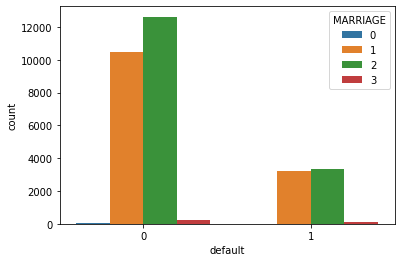

In [135]:
sns.countplot(x="default", hue="MARRIAGE", data=data);

Построим корреляцию V-Крамера между признаками MARRIAGE и default

In [146]:
chi_square = scipy.stats.chi2_contingency(pd.crosstab(data["default"], data["MARRIAGE"]), correction=False)[0]
n = len(data)
k_min = 2

In [147]:
v_cramer = (chi_square / n) ** .5

In [148]:
v_cramer

0.034478203662766466

In [149]:
scipy.stats.chi2_contingency(pd.crosstab(data["default"], data["MARRIAGE"]), correction=False)[1]

8.825862457577375e-08

С достигаемым уровнем значимости 8.825862457577375e-08 гипотезу о независимости наблюдаемых частот на уровне значимости 0.05 можно отвергнуть  
коэффициент V-Крамера ровняется 0.034478203662766466, что достаточно мало и может говорить об практической незначимости результатов

### Задание 5

Возраст (Age).  
Гипотезы о:

a)  о равенстве медианных значений возрастов людей против двухсторонней альтернативы

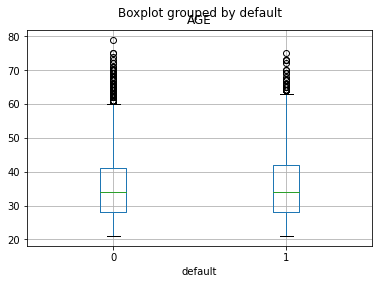

In [150]:
data.boxplot(column=["AGE"], by="default");

In [151]:
ret_age = ret.AGE
not_ret_age = not_ret.AGE

Гипотезу о равенстве медианы против двухсторонней альтернативы будем проверять критерием Краскела-Уоллиса для проверки равенста медиан (H0)  
против двухсторонней альтернативы.

In [152]:
scipy.stats.kruskal(ret_age, not_ret_age)

KruskalResult(statistic=0.795297355578892, pvalue=0.3725031126820255)

Гипотезу о равенстве медиан H0 на уровне значимости p = 0.05 мы не можем отклонить. Достигаемый уровень значимости: 0.3725031126820255

b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних, против двухсторонней альтернативы
Воспользуемся критерием Манна-Уитни

In [153]:
stats.mannwhitneyu(ret_age, not_ret_age)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.3725035434898616)

Гипотезу о равестве распределений отклонить невозможно на достигаемом уровне значимости 0.3725035434898616

In [154]:
zconfint(ret_age), zconfint(not_ret_age)

((35.300871020374075, 35.53366073788649),
 (35.49251465370673, 35.958962139542216))

In [155]:
zconfint(ret_age)[1] - zconfint(not_ret_age)[0]

0.04114608417976484

Доверительные интервалы говорят нам, что значения в выборках варьируются слабо и разница не будет значима практически